In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from shapely.geometry import Point

import statistics
import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [89]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [91]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_parquet(f'data/{target_column}_{city}.parquet',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [100]:
for city, state, conties in cities:
    df0 = pd.read_parquet(f'data/S000_{city}.parquet')
    print(df0.shape)

(4652649, 6)
(5480281, 6)
(1737124, 6)
(617796, 6)
(270400, 6)
(839056, 6)
(147456, 6)
(133956, 6)
(393129, 6)
(279841, 6)
(138384, 6)
(47524, 6)


In [92]:
for city, state, conties in cities:
    df0 = pd.read_parquet(f'data/S000_{city}.parquet')
    df1 = pd.read_parquet(f'data/SE01_{city}.parquet')
    df3 = pd.read_parquet(f'data/SE03_{city}.parquet')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_parquet(f'data/income_{city}.parquet', index=False)

# baseline

### unconstrain model, power law

In [3]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [4]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = (results.params[0],subData['distance'].median())
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## linear f(d)

In [5]:
def unconstrained_bucked_linear_kpredict(test,target,k,binf):
    
    # linear interpolation to get f(d) value for each distance value
    # backfill to fill values for values in the fisrt and last half bins
    binfdf_interpolation = pd.DataFrame(binf).T
    binfdf_interpolation.columns = ['f(d)','distance']
    binfdf_interpolation['bin'] = binf.keys()
    binfdf_interpolation =  pd.concat([test[['distance']].drop_duplicates(),
                                       binfdf_interpolation]).sort_values(by='distance')
    binfdf_interpolation = binfdf_interpolation.set_index('distance')
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)'].interpolate(method='index')
    binfdf_interpolation = binfdf_interpolation.reset_index()
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)inter'].fillna(method='backfill')
    binfdf_interpolation = binfdf_interpolation[['distance','f(d)inter']]
    binfdf_interpolation.columns = ['distance',target+'_f(d)inter']
    
    test = test.merge(binfdf_interpolation,on='distance',how='left')
    test[target+'k'] = k
#     test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'_f(d)inter']*test[target+'jobs']*test[target+'residence']
    return test

In [6]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

# start point

In [6]:
citiesList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego', 'Dallas', 'San Jose', 'Austin']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236, 1.540729, 1.480432, 2.497922]
startPoints = dict(zip(citiesList, points))

## find optimal bin

#### determined to use 40 bins from the figure above

In [8]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
    thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        # not enough datapoints in a bin
        if len(df.loc[df['bin']==binNo]) < thre:
            # index of current bin
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)
            # how many datapoints are needed from other bins
            addedVolume = thre - len(df.loc[df['bin']==binNo])
            
            # do we have enough datapoints on the left side
            if indexes[0] > int(addedVolume/2):
                # left side
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                                            # right side
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [57]:
# 5-fold 
resultslfd40is = {}
resultsBaselineis = {}
rate, number = 0.005,2000

for bins in np.linspace(10,50,9):
    print(bins)
    bins = int(bins)
    resultslfd40is[bins] = {}
    resultslfd40os[bins] = {}
    resultsBaselineis[bins] = {}
    resultsBaselineos[bins] = {}
    for city,state, counties in cities:
        if city in citieeList:
            print(city)
            df = pd.read_parquet(f'data/income_{city}.parquet')
            df['distance'] = df['distance']/1.6
            startpoint = startPoints[city]/1.6
            # include 95% of distance 
            startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
            afterendpointPercentage = 0.05 - startpointPercentage
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
            df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
            df['logDist'] = np.log(df['distance'])
     
            
            distBin = np.linspace(np.log(startpoint),np.log(endPoint),bins+1)
            df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
            df = mergeBin(df,rate,number)

            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
                # fd
            for target in ['S000']:
                print(target)

                fdmseis = 0
                fdmseos = 0
                lfdmseis = 0
                lfdmseos = 0
                blmseis = 0
                blmseos = 0
                for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
                    traindf, testdf = df.iloc[train_index], df.iloc[test_index]
                    binf,k = unconstrained_bucked_constant_kfit(traindf, target)

                    # linear interpolated f(d), include distance in formulation
                    df_lfdis = unconstrained_bucked_linear_kpredict(traindf,target,k,binf)
                    df_lfdos = unconstrained_bucked_linear_kpredict(testdf,target,k,binf)

                    lfdmseis += mean_squared_error(df_lfdis[target+'flow'],df_lfdis[target+'pred'])
                    lfdmseos += mean_squared_error(df_lfdos[target+'flow'],df_lfdos[target+'pred'])


                # baseline 
                    pars = baseline_fit(traindf,target)
                    df_baselineis = baseline_predict(traindf,target,pars)
                    df_baselineos = baseline_predict(testdf,target,pars)
                    blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
                    blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])


                resultslfd40is[bins][city] = resultslfd40is.get(city,[])+ [lfdmseis/5]
                resultslfd40os[bins][city] = resultslfd40os.get(city,[])+ [lfdmseos/5]

                resultsBaselineis[bins][city] = resultsBaselineis.get(city,[]) + [blmseis/5]
                resultsBaselineos[bins][city] = resultsBaselineos.get(city,[]) + [blmseos/5]

10.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
15.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
20.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
25.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
30.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
Dallas
S000
San Jose
S000
Austin
S000
35.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadel

In [58]:
resultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultslfd40os[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    resultsdf = pd.concat([resultsdf,temp])

blresultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultsBaselineos[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    blresultsdf = pd.concat([blresultsdf,temp])

In [59]:
citiBin = {}
for city in citieeList:
    index = np.argmin((resultsdf[city] - blresultsdf[city]).values)
    citiBin[city] = resultsdf['bins'].values[index]
citiBin

{'New York City': 20,
 'Los Angeles': 50,
 'Chicago': 40,
 'Houston': 40,
 'Boston': 15,
 'Phoenix': 45,
 'Philadelphia': 35,
 'San Antonio': 15,
 'San Diego': 45,
 'Dallas': 30,
 'San Jose': 15,
 'Austin': 15}

In [82]:
for city in citiBin.keys():
    fdmse = resultsdf.loc[resultsdf['bins']==citiBin[city]][city].values[0]
    blmse = blresultsdf.loc[blresultsdf['bins']==citiBin[city]][city].values[0]
    print(city,'bins:',citiBin[city],', f(d) MSE:',round(fdmse,2),'baseline MSE:',round(blmse,2) )

New York City bins: 50 , f(d) MSE: 7.24 baseline MSE: 7.26
Los Angeles bins: 40 , f(d) MSE: 6.92 baseline MSE: 6.99
Chicago bins: 35 , f(d) MSE: 15.95 baseline MSE: 16.9
Houston bins: 30 , f(d) MSE: 39.63 baseline MSE: 40.0
Boston bins: 15 , f(d) MSE: 44.65 baseline MSE: 45.02
Phoenix bins: 50 , f(d) MSE: 17.67 baseline MSE: 17.82
Philadelphia bins: 35 , f(d) MSE: 43.43 baseline MSE: 44.37
San Antonio bins: 15 , f(d) MSE: 43.58 baseline MSE: 43.63
San Diego bins: 45 , f(d) MSE: 49.16 baseline MSE: 51.28


# train on the whole dataset to get curves


In [9]:
citiBin = {'New York City': 20,
 'Los Angeles': 50,
 'Chicago': 40,
 'Houston': 40,
 'Boston': 15,
 'Phoenix': 45,
 'Philadelphia': 35,
 'San Antonio': 15,
 'San Diego': 45,
 'Dallas': 30,
 'San Jose': 15,
 'Austin': 15}

In [72]:
df = pd.read_parquet(f'data/income_{city}.parquet')
df

,origin,destination,distance_x,S000residence,S000jobs,S000flow,distance_y,SE01residence,SE01jobs,SE01flow,distance,SE03residence,SE03jobs,SE03flow
0,48453000402,48453001912,11.122912,1585,4545.0,5.0,11.122912,275,322.0,0.0,11.122912,844,3568.0,4.0
1,48453000402,48453001916,15.845681,1585,1083.0,3.0,15.845681,275,200.0,0.0,15.845681,844,585.0,0.0
2,48453000402,48453001783,15.750058,1585,459.0,2.0,15.750058,275,94.0,0.0,15.750058,844,227.0,2.0
3,48453000402,48453001918,9.294831,1585,4371.0,8.0,9.294831,275,752.0,1.0,9.294831,844,2499.0,7.0
4,48453000402,48453001784,20.602694,1585,1702.0,1.0,20.602694,275,396.0,0.0,20.602694,844,842.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47519,48453002424,48453002424,1.538283,1508,558.0,14.0,1.538283,298,130.0,2.0,1.538283,668,231.0,8.0
47520,48453001742,48453001742,2.830620,2267,1417.0,153.0,2.830620,340,311.0,28.0,2.830620,1383,691.0,65.0
47521,48453001760,48453001760,4.107266,5101,3080.0,614.0,4.107266,782,569.0,235.0,4.107266,3594,1912.0,271.0
47522,48453001826,48453001826,1.296967,867,1233.0,20.0,1.296967,169,239.0,0.0,1.296967,460,496.0,9.0


In [13]:
bindffDict = {}
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}

rate = 0.005
number = 2000


for city,state, counties in cities:
    if city in citieeList:
        print(city)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        print(startpoint,endPoint)
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(np.log(startpoint),np.log(endPoint),citiBin[city]+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)
        # fd
        for target in ['SE01','SE03','S000']:
            binf,k = unconstrained_bucked_constant_kfit(df, target)
            print(target)
            df_fdis = unconstrained_bucked_linear_kpredict(df,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'_f(d)inter']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'_f(d)inter']))
#             print(bindDict)
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
    
        income1 = bindffDict[city][0]
        income3 = bindffDict[city][1]
        income0 = bindffDict[city][2]
        distList = []
        fdList = []
        for bins in income1.keys():

            dist = df.loc[df['bin']==bins]['distance'].mean()
            fd = income1[bins]
            distList += [dist]
            fdList += [fd]
            fdDict = dict(zip(distList,fdList))
            Distfd1[city] = dict(sorted(fdDict.items()))
        distList = []
        fdList = []
        for bins in income3.keys():
            dist = df.loc[df['bin']==bins]['distance'].mean()
            fd = income3[bins]
            distList += [dist]
            fdList += [fd]
            fdDict = dict(zip(distList,fdList))
            Distfd3[city] = dict(sorted(fdDict.items()))


New York City
0.30037187499999995 18.56300589107707
SE01
SE03
S000
Los Angeles
0.6990231249999999 43.7271445959324
SE01
SE03
S000
Chicago
0.63866875 31.888847633576454
SE01
SE03
S000
Houston
1.130979375 34.776802575823154
SE01
SE03
S000
Boston
1.0389837499999999 29.004462126670933
SE01
SE03
S000
Phoenix
1.148223125 40.905826924273455
SE01
SE03
S000
Philadelphia
0.45702624999999997 13.511822569033606
SE01
SE03
S000
San Antonio
1.3015899999999998 23.324006206879567
SE01
SE03
S000
San Diego
1.2452249999999998 41.822104264910095
SE01
SE03
S000
Dallas
0.962955625 24.43782375642617
SE01
SE03
S000
San Jose
0.9252699999999999 28.273377353442097
SE01
SE03
S000
Austin
1.5612012499999999 23.157621493544717
SE01
SE03
S000


In [18]:
import json

# create json object from dictionary
jsons = json.dumps(Distfd1)

# open file for writing, "w" 
f = open("Distfd1.json","w")

# write json object to file
f.write(jsons)

# close file
f.close()

jsons = json.dumps(Distfd3)

# open file for writing, "w" 
f = open("Distfd3.json","w")

# write json object to file
f.write(jsons)

# close file
f.close()

## Plot income-level f(d) curves

In [3]:
import json

f = open('Distfd1.json')
Distfd1 = json.load(f)

f = open('Distfd3.json')
Distfd3 = json.load(f)

citiesList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego', 'Dallas', 'San Jose', 'Austin']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236, 1.540729, 1.480432, 2.497922]
startPoints = dict(zip(citiesList, points))

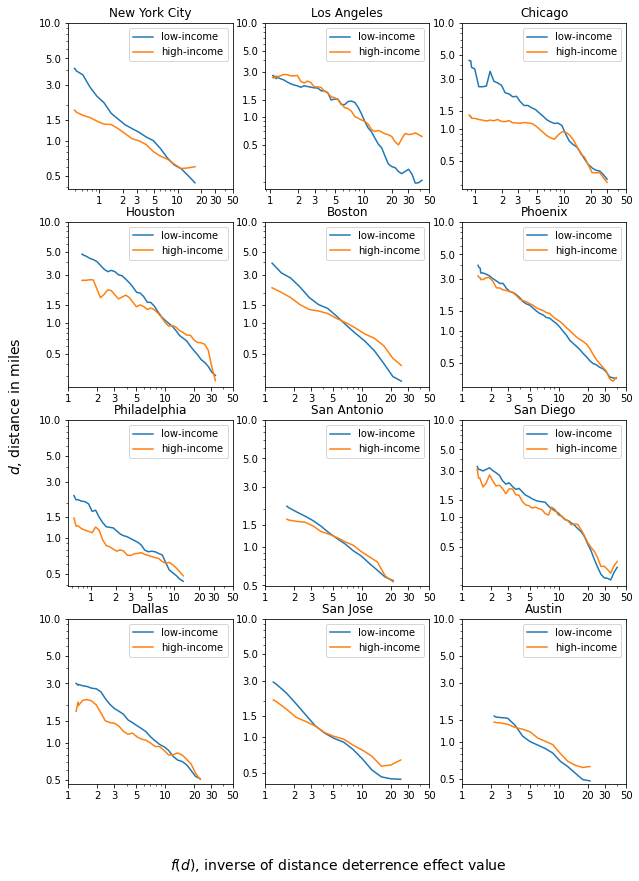

In [4]:
fig,ax = plt.subplots(4,3,figsize=(10,14))
i= 0
for city,state, counties in cities:
    if city in citiesList:
        ax[i//3,i%3].plot([float(i) for i in Distfd1[city].keys()],Distfd1[city].values(),label='low-income')
        ax[i//3,i%3].plot([float(i) for i in Distfd3[city].keys()],Distfd3[city].values(),label='high-income')
        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        ax[i//3,i%3].set_yscale('log')
        ax[i//3,i%3].set_xscale('log')
        ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
        ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
        ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#         ax[i//3,i%3].set_ylabel('$f(d)$, distance deterrence effect value',fontsize=12)
#         ax[i//3,i%3].set_xlabel('$d$, distance in miles',fontsize=12)
        i += 1
        
fig.text(0.5, 0.04, '$f(d)$, inverse of distance deterrence effect value',fontsize=14, ha='center')
fig.text(0.04, 0.5, '$d$, distance in miles',fontsize=14, va='center', rotation='vertical')

plt.savefig('img/curve.png',dpi=300)

### privilege zone

https://data.census.gov/cedsci/table?q=means%20of%20commute&g=0500000US36061&tid=ACSST5Y2018.S0802

LA 281544/4931598
Chicago 496282/2552596
Houston 55548/2263632
Boston (110172+114242)/(893202+458072)
Phoenix 42488/2166639
Philadelphia 181698/711264
San Antonio 181698/711264
San Diego 47478/1671791
Dallas 32191/1308392
San Jose 47636/995301
Austin 18617/719100

In [ ]:
## percentage of commuters taking public transit

publictransit = {'New York City': 0.559,
 'Los Angeles': 0.057,
 'Chicago': 0.194,
 'Houston': 0.02,
 'Boston': 0.166,
 'Phoenix':0.019 ,
 'Philadelphia': 0.255,
 'San Antonio':0.024 ,
 'San Diego': 0.028,
 'Dallas':0.024 ,
 'San Jose':0.047 ,
 'Austin': 0.025}

size = {'New York City': 302,
 'Los Angeles': 4753,
 'Chicago': 1635,
 'Houston': 1778,
 'Boston': 2705,
 'Phoenix':9224 ,
 'Philadelphia': 143,
 'San Antonio':1256 ,
 'San Diego': 4261,
 'Dallas':909 ,
 'San Jose':1304 ,
 'Austin': 1023}

In [361]:
def intersection_point(curve1,curve3):
    '''find intersection point for each bin,
    list point is all intersection points x values,
    section is the intersection lies in which bin'''  
    point = []
    section = []
    for p in range(len(curve1)):
        if p < len(curve1)-1:
            '''x1,x2 are start and end points of a distance bin'''
            '''y1 y2 are f(d) of SE01, z1 z2 are f(d) of SE03'''
            x1,x2,y1,y2,z1,z2 = curve1[p][0],curve1[p+1][0],curve1[p][1],curve1[p+1][1],curve3[p][1],curve3[p+1][1]
            k1 = (y2-y1)/(x2-x1)
            b1 = y1 - k1*x1
            k3 = (z2-z1)/(x2-x1)
            b3 = z1 - k3*x1
            
            if k1 != k3:
                x_intersect = (b3-b1)/(k1-k3)
                if x_intersect > x1 and x_intersect < x2:
                    # after the intersection , SE03 > SE01 or not
                    if z2 > y2:
                        section += [1]
                    else:
                        section += [0]
                        
                    point += [x_intersect]
                    
    return (point,section)



In [449]:
def all_privilege_zone(curve1,curve3):
    point,section = intersection_point(curve1,curve3)
    '''find the longest priviledge zone'''
    
    if len(point) > 1:
        privilege_zone = []
        start = 0
        end = 0
        startpoint = 0
        endpoint = 0
        for dist,status in list(zip(point,section)):
            if status == 1:
                # only when number of start point equal to number of end point
                # we can start to search a new privilege section
                if start == end:
                    startpoint = dist
                    start += 1
            elif status == 0:
                # when number of start = end + 1
                # it means we have an unclosed privilege section
                if start == end+1:
                    endpoint = dist
                    end +=1
            if start == end:
                privilege_zone += [(startpoint,endpoint)]
        if section[-1] == 1:
            privilege_zone += [(point[-1],curve1[-1][0])]
        if section[0] == 0:
            privilege_zone += [(curve1[0][0],point[0])]
    else:
        if section[0] == 1:
            privilege_zone = [(point[0],curve1[-1][0])]
        
    return privilege_zone

def the_longest_privilege_zone(curve1,curve3):
    privilege_zone = all_privilege_zone(curve1,curve3)
    length = 0
    longest_zone = ()
    for start,end in privilege_zone:
        if end - start > length:
            length = end - start
            longest_zone = (start,end)
                
    return(length, longest_zone)

def all_nonprivilege_zone(curve1,curve3):
    privilege_zone = all_privilege_zone(curve1,curve3)
    nonprivilege_zone = []
    ind = 0
#     print(len(privilege_zone))
    if len(privilege_zone)>1:
    # add the first and last section
        if privilege_zone[0][0] > curve1[0][0]:
            nonprivilege_zone += [(curve1[0][0],privilege_zone[0][0])]
        if privilege_zone[-1][0] < curve1[-1][0]:
            nonprivilege_zone += [(privilege_zone[-1][0],curve1[-1][0])]
        for start,end in privilege_zone:
            if ind+1 < len(privilege_zone):
    #             print(ind)
                nonprivilege_zone += [(end,privilege_zone[ind+1][0])]
            ind += 1
    else:
        # only one privilege zone and it ends before the curve ends
        if privilege_zone[0][-1] < curve1[-1][0]:
            nonprivilege_zone = [(privilege_zone[-1][0],curve1[-1][0],)]
        else:
            nonprivilege_zone = [(curve1[0][0],privilege_zone[0][0])]
    return nonprivilege_zone

In [450]:
city = 'Los Angeles'

curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
point,section = intersection_point(curve1,curve3)
point,section

([1.1266576021380463,
  3.8050244739410726,
  4.206306541450111,
  5.300407899693054,
  5.331619639429272,
  5.894541171814961,
  10.266292883499988],
 [1, 0, 1, 0, 1, 0, 1])

In [451]:
for city,state, counties in cities:
    if city in citiesList:
        print(city)
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        print(curve1[0][0], curve3[-1][0])
        print(all_privilege_zone(curve1,curve3))
        print(all_nonprivilege_zone(curve1,curve3))

New York City
0.48484123421266834 16.621919514387343
[(8.42954055814177, 16.621919514387343)]
[(0.48484123421266834, 8.42954055814177)]
Los Angeles
1.0743986769753735 41.90495900845505
[(1.1266576021380463, 3.8050244739410726), (4.206306541450111, 5.300407899693054), (5.331619639429272, 5.894541171814961), (10.266292883499988, 41.90495900845505)]
[(1.0743986769753735, 1.1266576021380463), (10.266292883499988, 41.90495900845505), (3.8050244739410726, 4.206306541450111), (5.300407899693054, 5.331619639429272), (5.894541171814961, 10.266292883499988)]
Chicago
0.8549389645810281 30.32009135317094
[(10.1818480051337, 14.547048704668251), (15.908309752644117, 18.319744034980797)]
[(0.8549389645810281, 10.1818480051337), (15.908309752644117, 30.32009135317094), (14.547048704668251, 15.908309752644117)]
Houston
1.3820284815697295 33.25777743450058
[(11.720557091128192, 31.99961639500248)]
[(11.720557091128192, 33.25777743450058)]
Boston
1.1743255590410946 25.567615163230872
[(6.232551121923133

In [377]:
privilegeCommutersRate = {}
privilegeZoneLength = {}
for city,state, counties in cities:
    if city in citiesList:
        print(city)
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        SE03_in_privilege = df.loc[df['distance'].between(privilege_zone[0],privilege_zone[1])]['SE03flow'].sum()
        SE03_total = df['SE03flow'].sum()
        privilegeCommutersRate[city] = (round(SE03_in_privilege/SE03_total,2))
        privilegeZoneLength[city] = length
        print(SE03_in_privilege,SE03_total,round(SE03_in_privilege/SE03_total,2))

New York City
382977.0 1622957.0 0.24
Los Angeles
246502.0 1525066.0 0.16
Chicago
155955.0 880230.0 0.18
Houston
332531.0 758240.0 0.44
Boston
247642.0 535213.0 0.46
Phoenix
679273.0 789865.0 0.86
Philadelphia
24947.0 160525.0 0.16
San Antonio
185616.0 254544.0 0.73
San Diego
44094.0 554047.0 0.08
Dallas
111275.0 364548.0 0.31
San Jose
314454.0 408291.0 0.77
Austin
170810.0 212610.0 0.8


In [378]:
scaler = MinMaxScaler()
sizevalues = scaler.fit_transform(np.array(list(size.values())).reshape(-1,1))
fitmodel = sm.OLS(sizevalues,np.array(list(privilegeCommutersRate.values())).reshape(-1,1)).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.439
Model:                            OLS   Adj. R-squared (uncentered):              0.388
Method:                 Least Squares   F-statistic:                              8.609
Date:                Thu, 28 Apr 2022   Prob (F-statistic):                      0.0136
Time:                        00:49:00   Log-Likelihood:                         -1.6559
No. Observations:                  12   AIC:                                      5.312
Df Residuals:                      11   BIC:                                      5.797
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4793      0.163      2.934      0.014       0.120       0.839
==============================================================================
Omnibus:                        1.838   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.399   Jarque-Bera (JB):                1.338
Skew:                           0.728   Prob(JB):                        0.512
Kurtosis:                       2.253   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

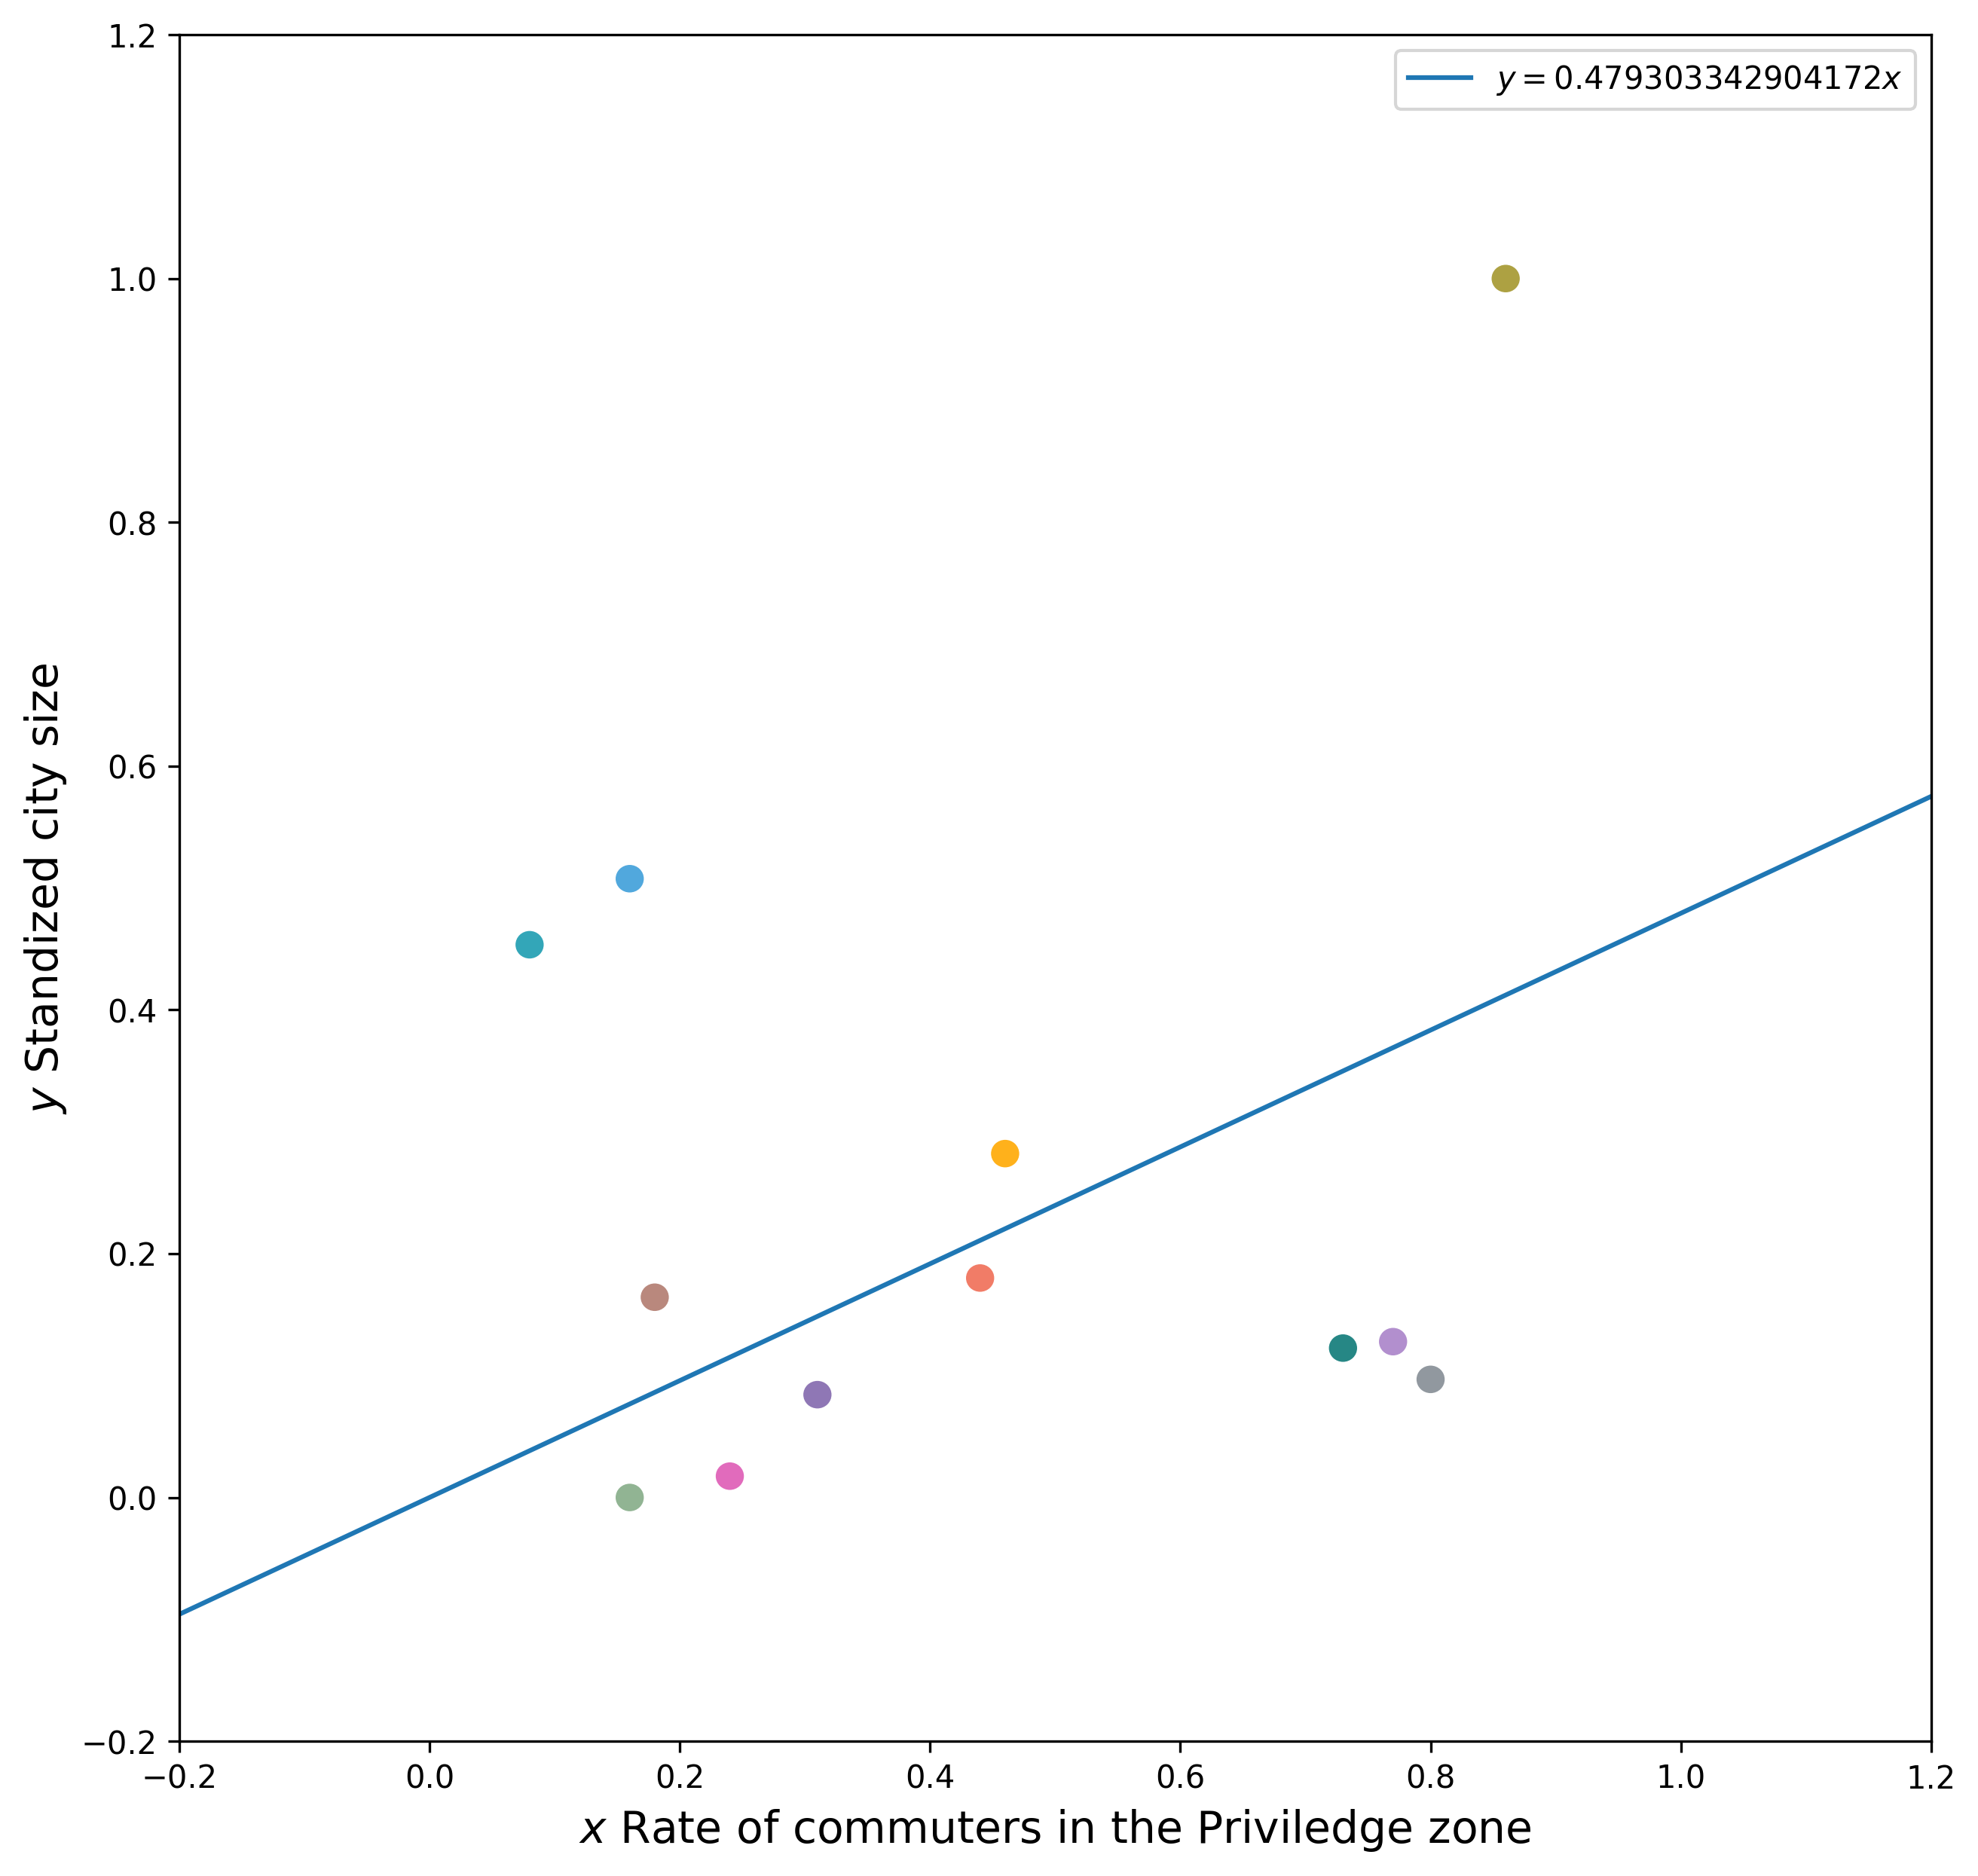

In [379]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0
for x, y, r in zip(list(privilegeCommutersRate.values()), sizevalues,
                       list(publictransit.values())):
    circle = plt.Circle((x, y), 0.01, color=colors[i])
    i += 1
    ax.add_patch(circle)
    
ax.set_xlabel('$x$ Rate of commuters in the Priviledge zone',fontsize=14)
ax.set_ylabel('$y$ Standized city size',fontsize=14)


plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
plt.axline(xy1=(0, 0), slope=m, label=f'$y = %sx$'%m)
plt.legend()
# plt.savefig('priviledge rate - size.png')

In [380]:
privilegeCommutersRate = {}
for city,state, counties in cities:
    if city in citiesList:
        print(city)
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        privilege_zone = all_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        SE03_in_privilege = 0
        for start,end in privilege_zone:
            SE03_in_privilege_sec = df.loc[df['distance'].between(start,end)]['SE03flow'].sum()
            SE03_in_privilege += SE03_in_privilege_sec
        SE03_total = df['SE03flow'].sum()
        privilegeCommutersRate[city] = (round(SE03_in_privilege/SE03_total,2))
        print(privilege_zone,round(SE03_in_privilege/SE03_total,2))

New York City
[(8.42954055814177, 16.621919514387343)] 0.24
Los Angeles
[(1.1266576021380463, 3.8050244739410726), (4.206306541450111, 5.300407899693054), (5.331619639429272, 5.894541171814961)] 0.27
Chicago
[(10.1818480051337, 14.547048704668251), (15.908309752644117, 18.319744034980797)] 0.22
Houston
[(11.720557091128192, 31.99961639500248)] 0.44
Boston
[(6.232551121923133, 25.567615163230872)] 0.46
Phoenix
[(4.1230731072931475, 31.8558884869568)] 0.86
Philadelphia
[(7.995154797210716, 12.84699306811967)] 0.16
San Antonio
[(5.1319129011751965, 19.20301904429809)] 0.73
San Diego
[(8.336722135952726, 9.444433223667975), (10.523877950735436, 12.063322745444568)] 0.14
Dallas
[(11.808218015519081, 22.689929725459347)] 0.31
San Jose
[(3.6920887464108065, 25.200671564542887)] 0.77
Austin
[(3.701150206790431, 20.992583931154538)] 0.8


In [381]:
scaler = MinMaxScaler()
sizevalues = scaler.fit_transform(np.array(list(size.values())).reshape(-1,1))
fitmodel = sm.OLS(sizevalues,np.array(list(privilegeCommutersRate.values())).reshape(-1,1)).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.481
Model:                            OLS   Adj. R-squared (uncentered):              0.434
Method:                 Least Squares   F-statistic:                              10.19
Date:                Thu, 28 Apr 2022   Prob (F-statistic):                     0.00857
Time:                        00:49:16   Log-Likelihood:                         -1.1897
No. Observations:                  12   AIC:                                      4.379
Df Residuals:                      11   BIC:                                      4.864
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4957      0.155      3.193      0.009       0.154       0.837
==============================================================================
Omnibus:                        1.776   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.411   Jarque-Bera (JB):                1.249
Skew:                           0.724   Prob(JB):                        0.535
Kurtosis:                       2.368   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

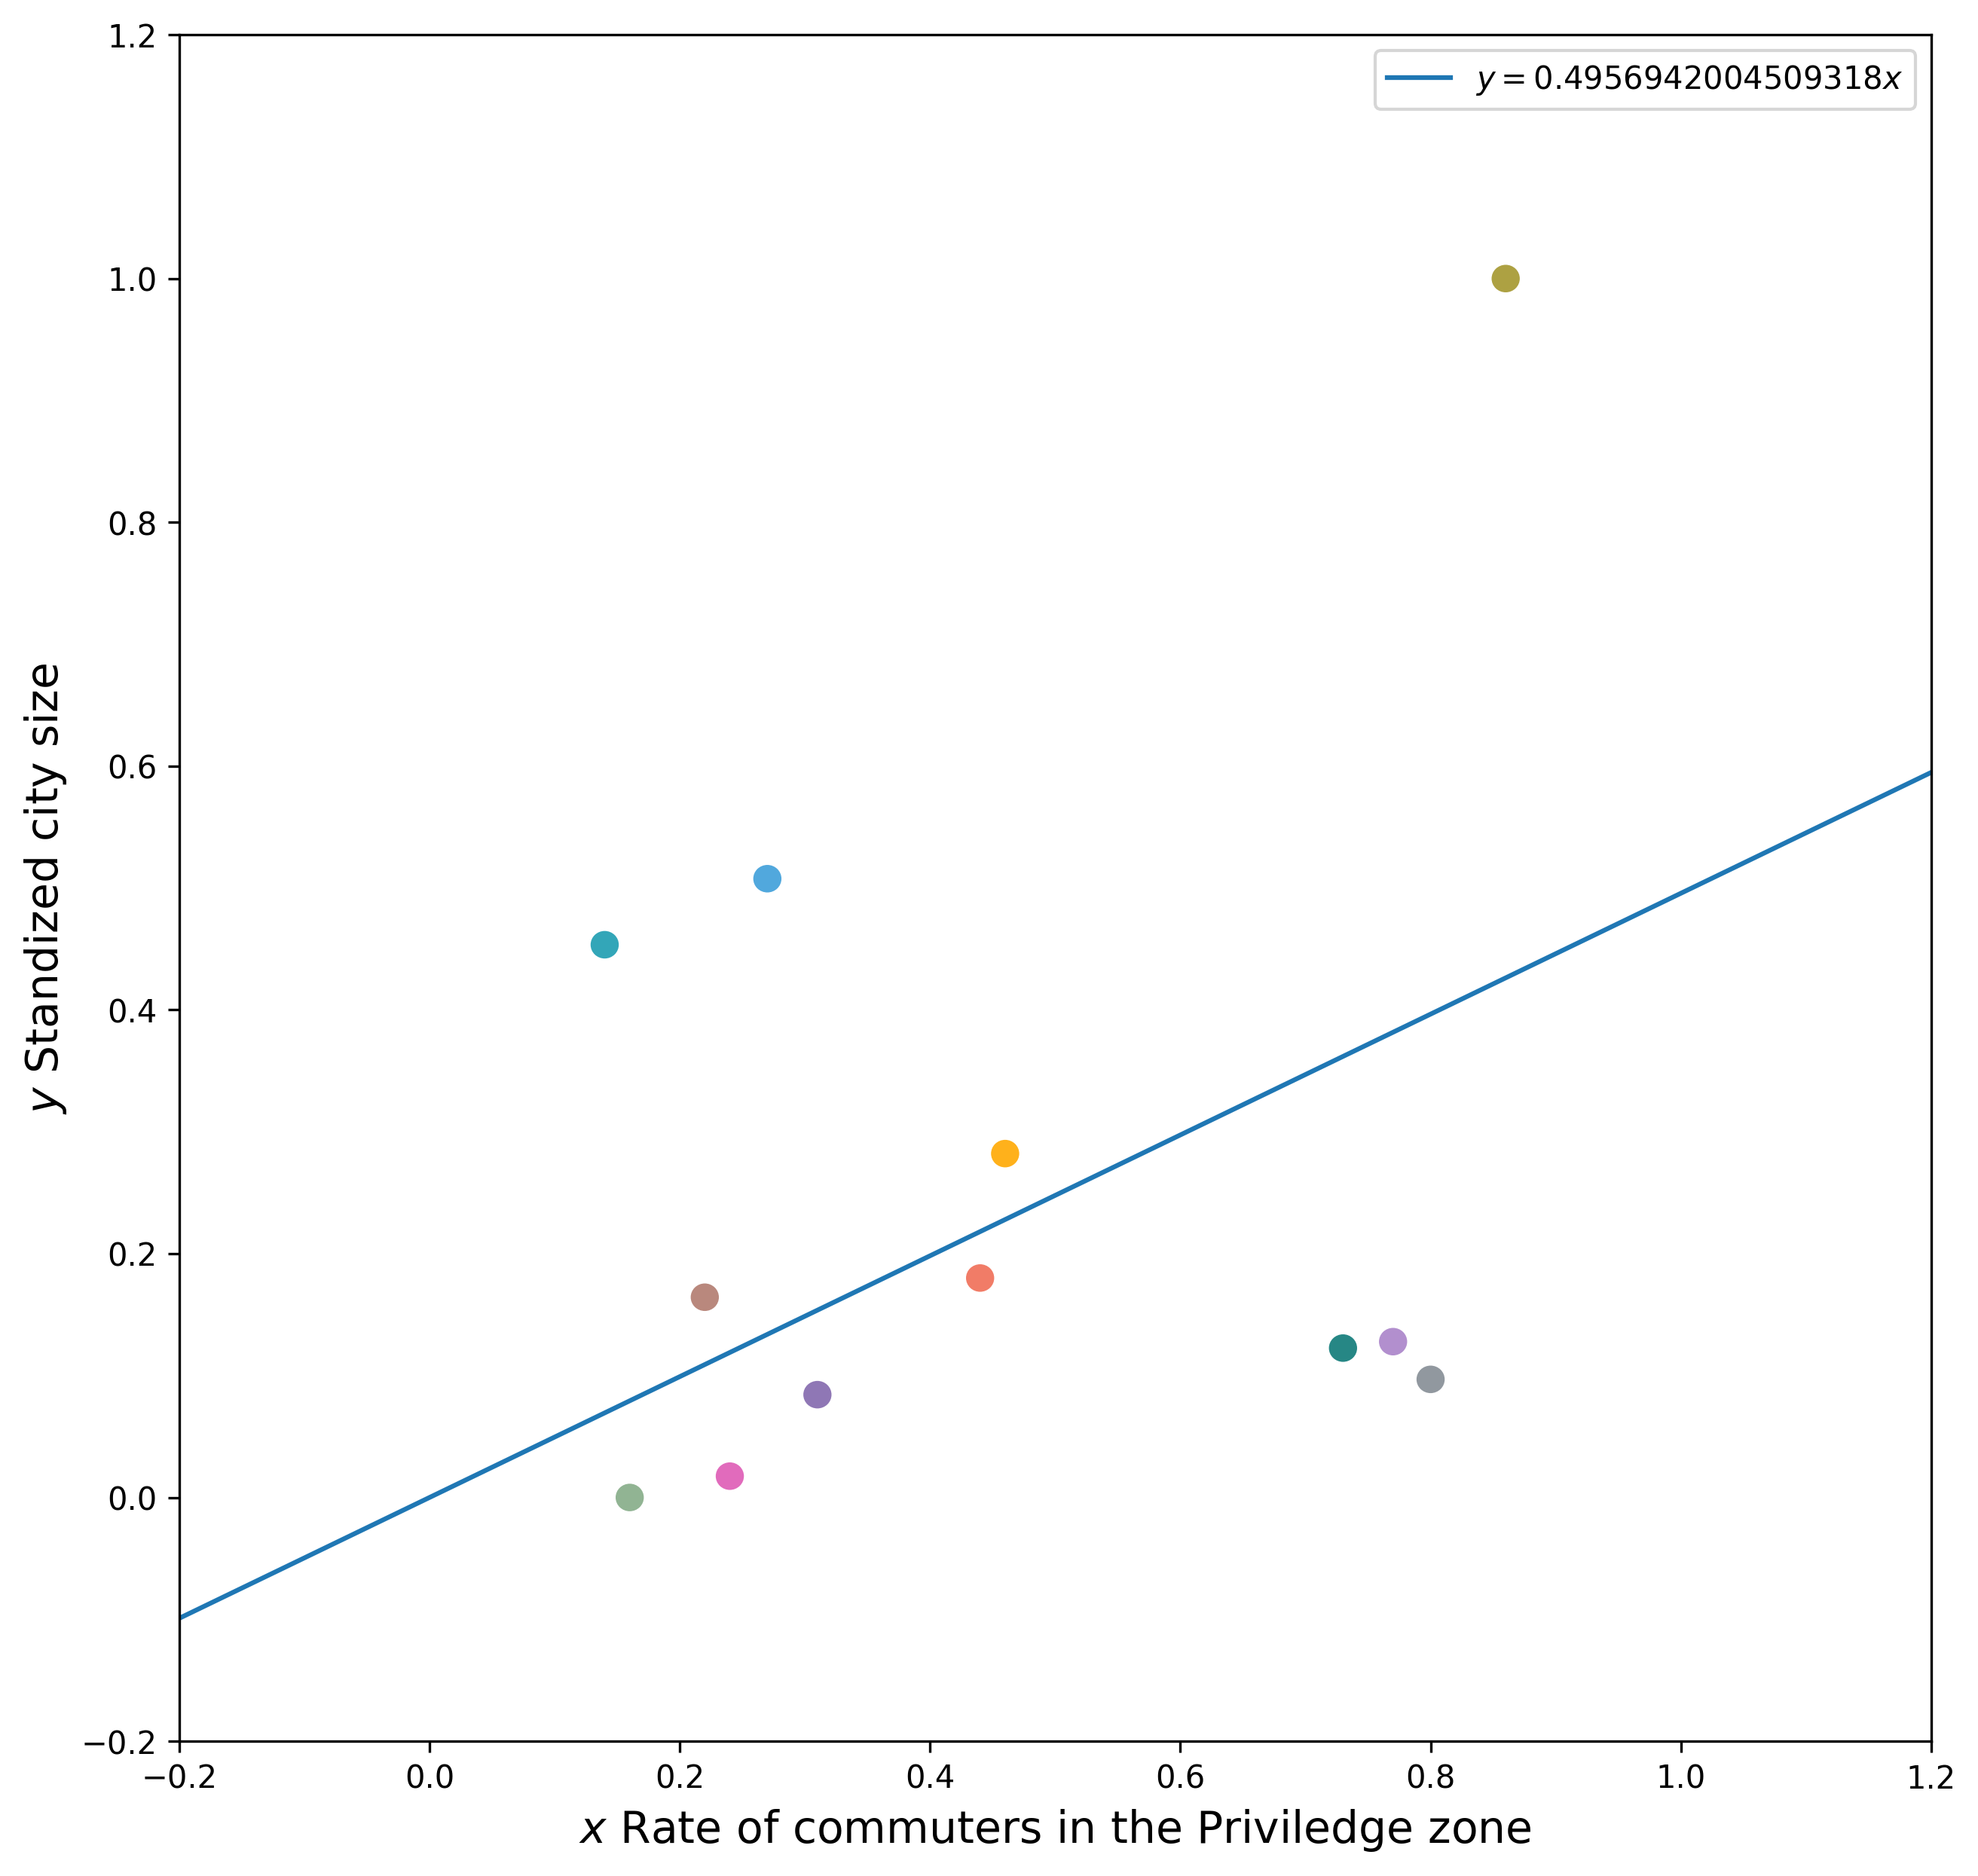

In [382]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10),dpi=300)

i = 0
for x, y, r in zip(list(privilegeCommutersRate.values()), sizevalues,
                       list(publictransit.values())):
    circle = plt.Circle((x, y), 0.01, color=colors[i])
    i += 1
    ax.add_patch(circle)
    
ax.set_xlabel('$x$ Rate of commuters in the Priviledge zone',fontsize=14)
ax.set_ylabel('$y$ Standized city size',fontsize=14)


plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
plt.axline(xy1=(0, 0), slope=m, label=f'$y = %sx$'%m)
plt.legend()
# plt.savefig('priviledge rate - size.png')

## privilege effect
gap integrated by %% of commuters

In [532]:
def privilegeEffect(privilege_zone,curve1,curve3,df):
    ind = 0
    totalarea = 0
    start = privilege_zone[0]
    end = privilege_zone[1]
    distList = []
    for dist,fd in curve1:
        if dist > start and dist < end:
            gap1 = (curve3[ind][1] - fd)/fd
            gap2 = (curve3[ind+1][1] - curve1[ind+1][1])/curve1[ind+1][1]
            commuter = df.loc[df['distance'].between(curve3[ind][0],curve3[ind+1][0]-1e-99,inclusive=True)]['SE03flow'].sum()
            area = (gap1+gap2)*commuter*0.5
            totalarea += area
            distList += [(ind,dist)]
#             print(dist,totalarea,commuter)
        ind += 1
#     print(distList)
    
    # if the privilege zone is a part of the last distance bin
    if len(distList) < 1:
        gap = (curve3[-1][1] - curve1[-1][1])/curve1[-1][1]
        commuter = df.loc[df['distance'].between(privilege_zone[1],curve3[-1][0],inclusive=True)]['SE03flow'].sum()
        area = gap*commuter*0.5
        totalarea += area
    else:
        # two triangles
        # the first triangle is between the first intersection point and the start of the first bin in privilege zone
        gap = (curve3[distList[0][0]][1] - curve1[distList[0][0]][1])/curve1[distList[0][0]][1]
        commuter = df.loc[df['distance'].between(distList[0][1],curve3[distList[0][0]][0]-1e-99,inclusive=True)]['SE03flow'].sum()
        area = gap*commuter*0.5
        totalarea += area

        # the second triangle is between the first intersection point and the end of the last bin in privilege zone
        # if the end of the last bin in distList is not in the privilege zone
        # the area of the second triangle is supposed to be a negatvie value
        if distList[-1][0]+1 < len(curve1):
            if curve3[distList[-1][0]+1][0] > privilege_zone[1]:
                gap = (curve3[distList[-1][0]+1][1] - curve1[distList[-1][0]+1][1])/curve1[distList[-1][0]+1][1]
                commuter = df.loc[df['distance'].between(distList[-1][1],curve3[distList[-1][0]+1][0],inclusive=True)]['SE03flow'].sum()
                area = gap*commuter*0.5
                totalarea += area
    #             print('end',curve3[distList[-1][0]+1][0],distList[-1][1])
    #             print('gap',curve3[distList[-1][0]+1][1] - curve1[distList[-1][0]+1][1],area)
    #             print(curve3[distList[-1][0]+1][0],totalarea,commuter)
    return totalarea

In [533]:
### privilege effect degree (gap between two curves integrated by %% of privilege commuters in this zone)
### privilege zone is the longest privilege zone

privilegeEffectValue = {}
for city,state, counties in cities:
    if city in citiesList:
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        totalarea = privilegeEffect(privilege_zone,curve1,curve3,df)
        totalSE03 = df.loc[df['distance'].between(privilege_zone[0],privilege_zone[1])]['SE03flow'].sum()
        print(city,totalarea/totalSE03)
        privilegeEffectValue[city] = totalarea/totalSE03

New York City 0.06590550626413079
Los Angeles 0.71826308794309
Chicago 0.07696948628786406
Houston 0.22830399022798298
Boston 0.24604151828161494
Phoenix 0.15945591300193984
Philadelphia 0.11451083937734091
San Antonio 0.08436785647254111
San Diego 0.1049013395319296
Dallas 0.09927673391080066
San Jose 0.13454987423139037
Austin 0.15261706154660756


In [536]:
scaler = MinMaxScaler()
normpublictransit = scaler.fit_transform(np.array(list(publictransit.values())).reshape(-1,1))

scaler = MinMaxScaler()
normprivilegeCommutersRate = scaler.fit_transform(np.array(list(privilegeCommutersRate.values())).reshape(-1,1))

fitmodel = sm.OLS(normprivilegeCommutersRate,sizevalues).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.429
Model:                            OLS   Adj. R-squared (uncentered):              0.377
Method:                 Least Squares   F-statistic:                              8.266
Date:                Fri, 29 Apr 2022   Prob (F-statistic):                      0.0151
Time:                        11:45:51   Log-Likelihood:                         -6.7163
No. Observations:                  12   AIC:                                      15.43
Df Residuals:                      11   BIC:                                      15.92
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9899      0.344      2.875      0.015       0.232       1.748
==============================================================================
Omnibus:                        0.375   Durbin-Watson:                   1.334
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.479
Skew:                           0.280   Prob(JB):                        0.787
Kurtosis:                       2.197   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


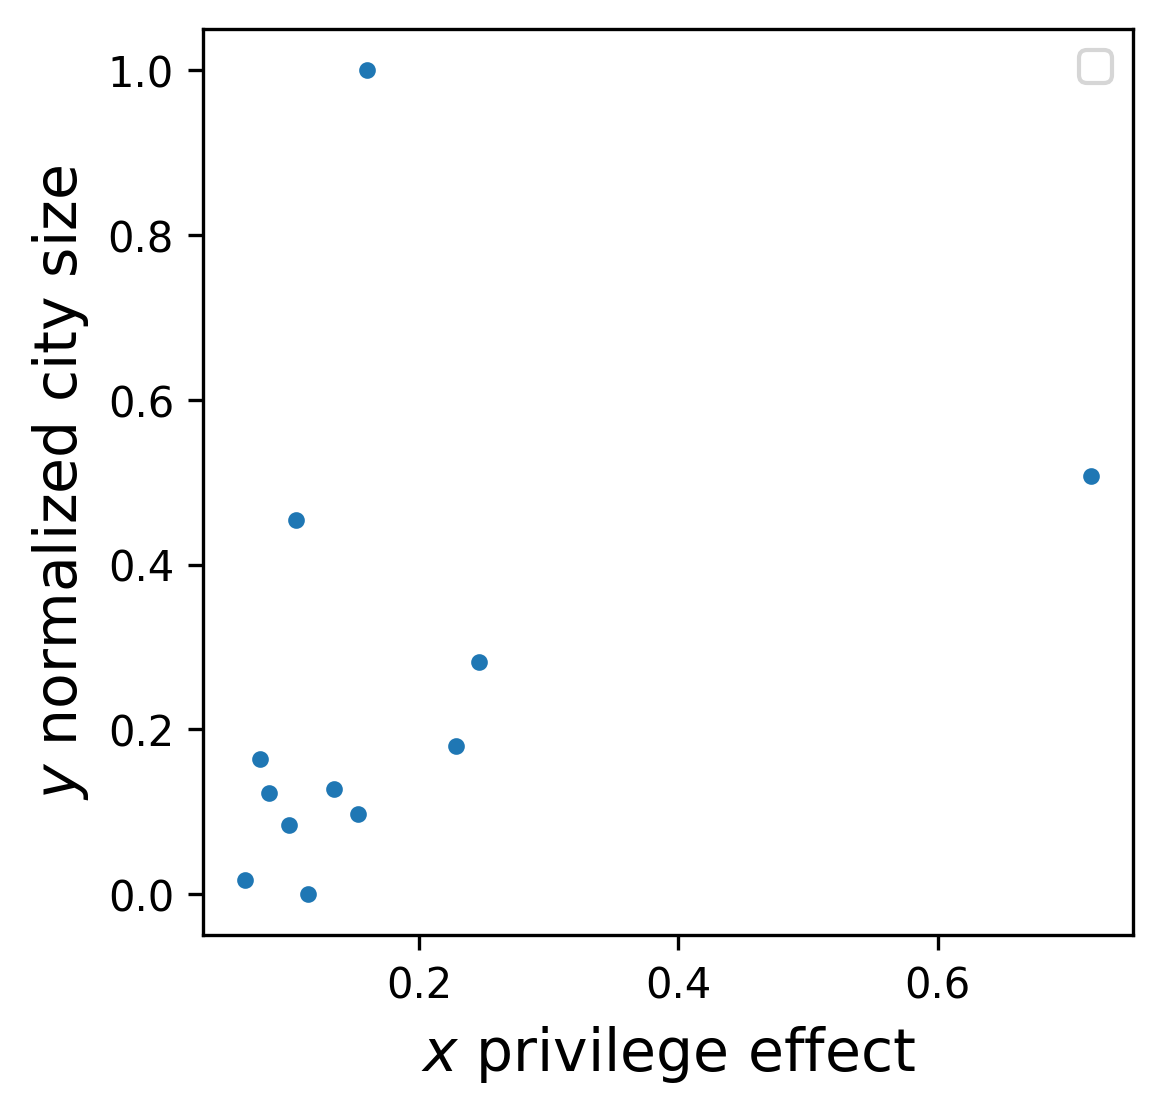

In [538]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(4,4),dpi=300)

i = 0

plt.plot(privilegeEffectValue.values(),sizevalues,'.')
    
ax.set_xlabel('$x$ privilege effect',fontsize=14)
ax.set_ylabel('$y$ normalized city size',fontsize=14)


# plt.xlim([-0.02, 0.12])
# plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
# plt.axline(xy1=(0.5, 0.5), slope=-0.8, label=f'$y = %sx$'%m)
plt.legend()
# plt.savefig('img/priviledge effect - public transit.png')

In [552]:
## population density
population = {'New York City': 8379552,
 'Los Angeles': 9818605,
 'Chicago': 5275542,
 'Houston': 4092459,
 'Boston': 2407061,
 'Phoenix':3817117 ,
 'Philadelphia': 1526006,
 'San Antonio':1714773 ,
 'San Diego': 3323970,
 'Dallas':2368139 ,
 'San Jose':1924379 ,
 'Austin': 1024266}

In [553]:
size

{'New York City': 302,
 'Los Angeles': 4753,
 'Chicago': 1635,
 'Houston': 1778,
 'Boston': 2705,
 'Phoenix': 9224,
 'Philadelphia': 143,
 'San Antonio': 1256,
 'San Diego': 4261,
 'Dallas': 909,
 'San Jose': 1304,
 'Austin': 1023}

In [559]:
scaler = MinMaxScaler()
normdensity = scaler.fit_transform((np.array(list(size.values()))/np.array(list(population.values()))).reshape(-1,1))

scaler = MinMaxScaler()
normprivilegeCommutersRate = scaler.fit_transform(np.array(list(privilegeCommutersRate.values())).reshape(-1,1))

fitmodel = sm.OLS(normprivilegeCommutersRate,normdensity).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.646
Method:                 Least Squares   F-statistic:                              22.88
Date:                Fri, 29 Apr 2022   Prob (F-statistic):                    0.000568
Time:                        14:32:37   Log-Likelihood:                         -3.3289
No. Observations:                  12   AIC:                                      8.658
Df Residuals:                      11   BIC:                                      9.143
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1565      0.242      4.784      0.001       0.624       1.689
==============================================================================
Omnibus:                        1.126   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.569   Jarque-Bera (JB):                0.268
Skew:                          -0.366   Prob(JB):                        0.874
Kurtosis:                       3.028   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

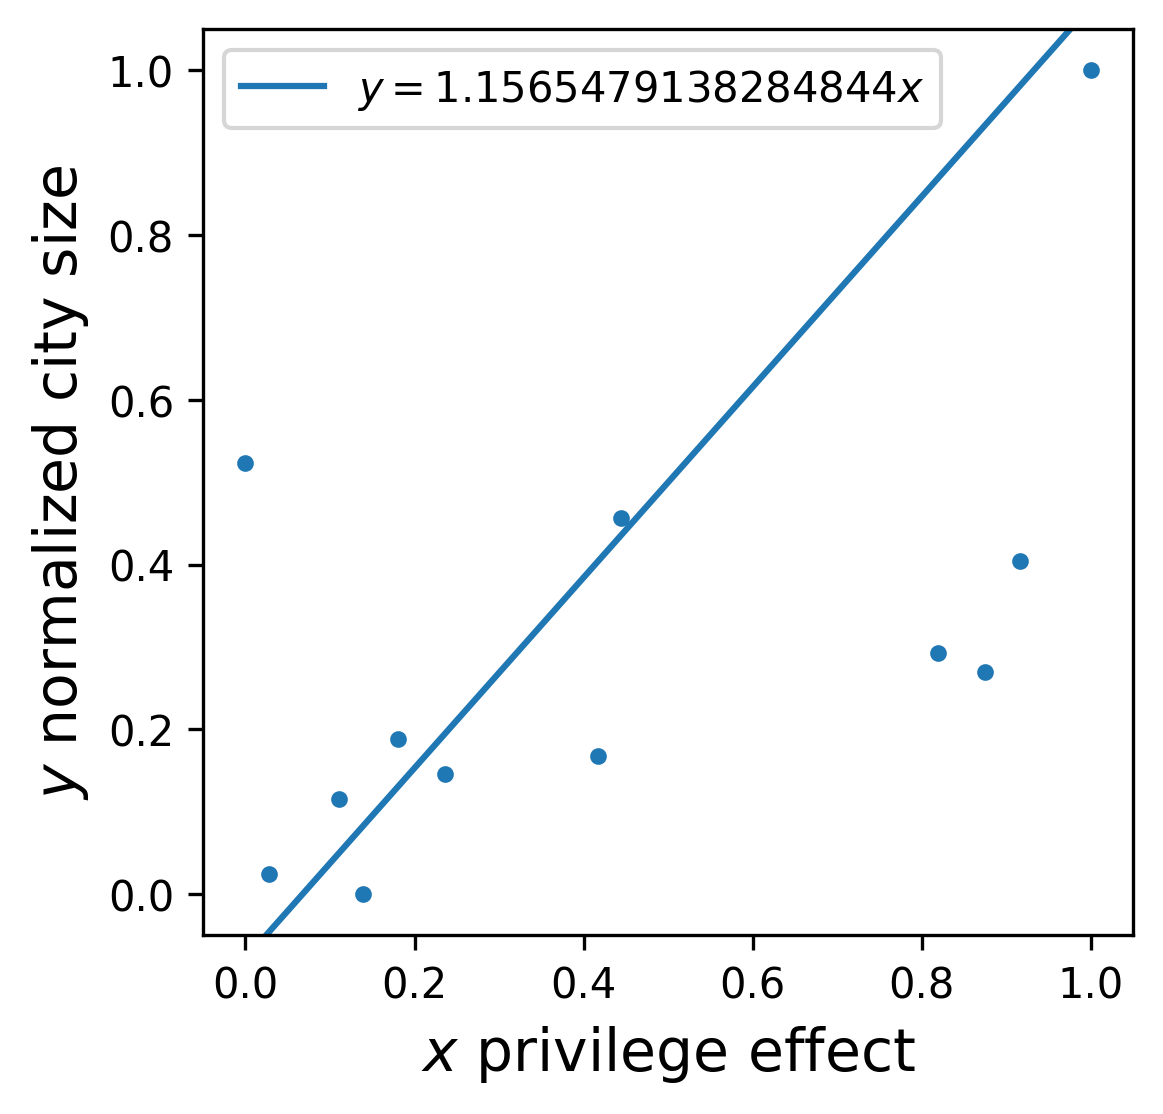

In [562]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(4,4),dpi=300)

i = 0

plt.plot(normprivilegeCommutersRate,normdensity,'.')
    
ax.set_xlabel('$x$ privilege effect',fontsize=14)
ax.set_ylabel('$y$ normalized city size',fontsize=14)


# plt.xlim([-0.02, 0.12])
# plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
plt.axline(xy1=(0.5, 0.5), slope=m, label=f'$y = %sx$'%m)
plt.legend()
# plt.savefig('img/priviledge effect - public transit.png')

In [ ]:
q1 = sum(percentage[:5])
q2 = sum(percentage[5:7])
q3 = percentage[7]
q4 = percentage[8]
q5 = percentage[9]

In [568]:
percentage

[0.055,
 0.046,
 0.078,
 0.076,
 0.107,
 0.158,
 0.12300000000000001,
 0.163,
 0.08199999999999999,
 0.111]

In [567]:
gdp_quintile_shares

[0, 0.362, 0.163, 0.08199999999999999, 0.111]

In [570]:
percentage

[0.055,
 0.046,
 0.078,
 0.076,
 0.107,
 0.158,
 0.12300000000000001,
 0.163,
 0.08199999999999999,
 0.111]

In [571]:
df

,Label (Grouping),"Los Angeles County, California!!Households!!Estimate","Los Angeles County, California!!Households!!Margin of Error","Los Angeles County, California!!Families!!Estimate","Los Angeles County, California!!Families!!Margin of Error","Los Angeles County, California!!Married-couple families!!Estimate","Los Angeles County, California!!Married-couple families!!Margin of Error","Los Angeles County, California!!Nonfamily households!!Estimate","Los Angeles County, California!!Nonfamily households!!Margin of Error"
0,Total,"3,332,504","±5,051","2,211,342","±8,593","1,493,670","±8,081","1,121,162","±7,233"
1,"Less than $10,000",5.5%,±0.1,3.5%,±0.1,1.6%,±0.1,10.7%,±0.2
2,"$10,000 to $14,999",4.6%,±0.1,2.3%,±0.1,1.4%,±0.1,9.5%,±0.2
3,"$15,000 to $24,999",7.8%,±0.1,6.9%,±0.1,5.2%,±0.1,10.5%,±0.2
4,"$25,000 to $34,999",7.6%,±0.1,7.4%,±0.1,5.8%,±0.1,8.7%,±0.2
5,"$35,000 to $49,999",10.7%,±0.1,10.8%,±0.2,9.0%,±0.2,11.1%,±0.2
6,"$50,000 to $74,999",15.8%,±0.2,16.0%,±0.2,14.7%,±0.2,15.4%,±0.3
7,"$75,000 to $99,999",12.3%,±0.1,12.7%,±0.2,12.9%,±0.2,11.0%,±0.3
8,"$100,000 to $149,999",16.3%,±0.1,17.8%,±0.2,20.0%,±0.2,12.3%,±0.3
9,"$150,000 to $199,999",8.2%,±0.1,9.4%,±0.1,11.8%,±0.2,5.0%,±0.2


In [578]:
for i,x in enumerate(df[df.columns[0]].values.tolist()[1:]):
    print(i,x)

0     Less than $10,000
1     $10,000 to $14,999
2     $15,000 to $24,999
3     $25,000 to $34,999
4     $35,000 to $49,999
5     $50,000 to $74,999
6     $75,000 to $99,999
7     $100,000 to $149,999
8     $150,000 to $199,999
9     $200,000 or more
10 Median income (dollars)
11 Mean income (dollars)
12 PERCENT ALLOCATED
13     Household income in the past 12 months
14     Family income in the past 12 months
15     Nonfamily income in the past 12 months


In [575]:
shares_cumsum

array([0.   , 0.179, 0.52 , 0.643, 0.806, 0.888, 0.999])

In [580]:
df = pd.read_csv('gini/Los Angeles.csv')
percentage = df[df.columns[1]].values.tolist()[1:11]
percentage = [float(i.replace('%',''))/100 for i in percentage]


q1 = sum(percentage[:3])
q2 = sum(percentage[3:5])
q3 = percentage[5]
q3 = percentage[6]
q4 = percentage[7]
q5 = percentage[8]
q6 = percentage[9]

gdp_quintile_shares = [0,q1,q2,q3,q4,q5,q6]
shares_cumsum = np.cumsum(a=gdp_quintile_shares, axis=None)

pe_line = np.linspace(start=0.0, stop=1.0, num=len(shares_cumsum))

area_under_lorenz = np.trapz(y=shares_cumsum, dx=1/len(shares_cumsum))
area_under_pe = np.trapz(y=pe_line, dx=1/len(shares_cumsum))
    
gini = (area_under_pe - area_under_lorenz) / area_under_pe
print('Gini coefficient:', gini)
# percentage = np.array(percentage).cumsum()
# percentage
# np.trapz(percentage, dx=10)
# perfect_curve = percentage[0] + percentage[-1]

Gini coefficient: 0.0584999999999999


In [563]:
    
GDP = 653200000000 # this value isn't actually needed
    
# Decile percents of global GDP
gdp_decile_percents = [0.49, 0.59, 0.69, 0.79, 1.89, 2.55, 5.0, 10.0, 18.0, 60.0]
print('Percents sum to 100:', sum(gdp_decile_percents) == 100)
    
gdp_decile_shares = [i/100 for i in gdp_decile_percents]
    
# Convert to quintile shares of total GDP
gdp_quintile_shares = [(gdp_decile_shares[i] + gdp_decile_shares[i+1]) for i in range(0, len(gdp_decile_shares), 2)]
    
# Insert 0 for the first value in the Lorenz curve
gdp_quintile_shares.insert(0, 0)
    
# Cumulative sum of shares (Lorenz curve values)
shares_cumsum = np.cumsum(a=gdp_quintile_shares, axis=None)
    
# Perfect equality line
pe_line = np.linspace(start=0.0, stop=1.0, num=len(shares_cumsum))

area_under_lorenz = np.trapz(y=shares_cumsum, dx=1/len(shares_cumsum))
area_under_pe = np.trapz(y=pe_line, dx=1/len(shares_cumsum))
    
gini = (area_under_pe - area_under_lorenz) / area_under_pe
    
print('Gini coefficient:', gini)

Percents sum to 100: True
Gini coefficient: 0.66944


In [564]:
gdp_quintile_shares

[0, 0.0108, 0.0148, 0.044399999999999995, 0.15000000000000002, 0.78]

## Monte Carlo simulation

In [66]:
NUM_POINTS = 20

def generate_random_points(shape):
    minx, miny, maxx, maxy = shape.bounds
    xc = (maxx - minx) * np.random.random(NUM_POINTS) + minx
    yc = (maxy - miny) * np.random.random(NUM_POINTS) + miny

    points = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
    filtered_points = points.loc[points.within(shape)]
    points_geo = list(zip(filtered_points.y, filtered_points.x))
    return points_geo
    
def get_avg_point_to_point_distance(shape_a, shape_b):
    points_a = generate_random_points(shape_a)
    points_b = generate_random_points(shape_b)
    common_points = min(len(points_a), len(points_b), 1)
    if common_points == 0:
        return None
    
    points_a_c = points_a[0:common_points]
    points_b_c = points_b[0:common_points]
    distance = haversine_vector(points_a_c, points_b_c, Unit.KILOMETERS)
    mean_distance = statistics.mean(distance)
    return mean_distance


SAMPLES = 20000


def get_avg_distance(gdf):
    output = []
    for i in range(SAMPLES):
        sample = gdf.sample(n = 2)

        shape_a = sample.reset_index().loc[0]["geometry"]
        shape_b = sample.reset_index().loc[1]["geometry"]
        id_a = sample.index[0]
        id_b = sample.index[1]
        avg_distance = get_avg_point_to_point_distance(shape_a, shape_b)
        if avg_distance is not None:
            output.append({'from': id_a, 'to': id_b, 'p2p_avg_distance': avg_distance})
    
    pdf = pd.DataFrame(output)
    return pdf

In [67]:
output = {}
for city, state, conties in cities:
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    training_set = build_training_set(city_network, 'S000')
    nodes = city_network.nodes
    avg_distance = get_avg_distance(nodes)
    
    merged = pd.merge(training_set, avg_distance,  how='inner', left_on=['origin','destination'], right_on = ['from','to'])
    merged_filtered = merged
    merged_filtered['delta'] = np.abs(merged_filtered.distance - merged_filtered.p2p_avg_distance)
    quantiles = merged_filtered.delta.quantile([.5, .6, .7, .8, .9, 0.95, 0.99])
    output[city] = quantiles.to_dict()
    error = merged_filtered.delta.mean() 
    print(f"{city}: {error}")

New York City: 0.23318465336358488
Los Angeles: 0.5880542251098596
Chicago: 0.47264545956451637
Houston: 0.8544507944813855
Boston: 0.7216409787770274
Phoenix: 1.0696908912977126
Philadelphia: 0.35620353722320486
San Antonio: 0.9753960859438853
San Diego: 0.9532767780401463
Dallas: 0.729267064123792
San Jose: 0.7819044087441388
Austin: 1.136174461579971


In [ ]:
pd.DataFrame(output)

,New York City,Los Angeles,Chicago,Houston,Boston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,Austin
0.50,0.176530,0.373929,0.349259,0.626014,0.483576,0.589840,0.277706,0.689228,0.563316,0.565688,0.485094,0.751230
0.60,0.220729,0.473481,0.443118,0.797668,0.639243,0.751285,0.347748,0.872422,0.722217,0.708454,0.615565,0.975461
0.70,0.277682,0.596798,0.564801,1.009724,0.837312,0.961928,0.431537,1.096358,0.909662,0.885414,0.781659,1.256536
0.80,0.351193,0.771752,0.736969,1.300103,1.133779,1.257603,0.543070,1.424256,1.229035,1.131133,1.013852,1.681846
0.90,0.485592,1.097315,1.021622,1.814740,1.670841,1.906330,0.729216,2.080797,1.932760,1.543676,1.496020,2.560253
0.95,0.640003,1.555651,1.317518,2.404259,2.250880,3.011811,0.933643,3.029391,3.037446,1.980435,2.248784,3.560927
0.99,1.091991,3.864622,2.119622,4.155098,3.541665,11.672539,1.558372,5.184831,7.811290,3.028761,5.252093,6.235240
